In [47]:
import pandas as pd
import datetime as dt

In [48]:
loc_history = pd.read_json("data/Histórico de localização.json")

In [49]:
locations = pd.json_normalize(loc_history['locations'])

In [50]:
locations.head()

,timestampMs,latitudeE7,longitudeE7,accuracy,activity,source,deviceTag,altitude,verticalAccuracy,platform,platformType,locationMetadata,velocity,heading
0,1378508750990,-229917099,-433592736,984,"[{'timestampMs': '1378508517137', 'activity': ...",CELL,248904379,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1378508766022,-229917099,-433592736,984,"[{'timestampMs': '1378508772583', 'activity': ...",CELL,248904379,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1378509026816,-229917099,-433592736,984,"[{'timestampMs': '1378508969051', 'activity': ...",CELL,248904379,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1378509072785,-229949469,-433592859,5,NaN,GPS,248904379,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1378509118790,-229958679,-433588200,5,NaN,GPS,248904379,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
locations['timestampMs'] = pd.to_numeric(locations['timestampMs'])
locations['latitudeE7'] = pd.to_numeric(locations['latitudeE7'])
locations['longitudeE7'] = pd.to_numeric(locations['longitudeE7'])

In [52]:
locations = locations[
    locations['timestampMs'] > dt.datetime.timestamp(dt.datetime.now() - dt.timedelta(days=30)) * 1000]

In [53]:
import requests
import time

In [54]:
####
# URL de conexão com a API CEP Aberto
####
with open('token.txt') as file:
    token = file.readline()

url = "https://www.cepaberto.com/api/v3/nearest"
headers = {'Authorization': 'Token token=' + token}

In [55]:
entries = pd.DataFrame()
initTimestamp = 0
initLatitude = 0
initLongitude = 0
for index, location in locations.iterrows():
    if initTimestamp == 0:
        initTimestamp = location['timestampMs']
        initLatitude = location['latitudeE7']
        initLongitude = location['longitudeE7']
    else:
        ####
        # Verifica se houve alguma mudança significativa na localização baseada nos dados de lat e lng fornecidos pelo GPS
        ####
        if abs(location['latitudeE7'] - initLatitude) > 50000 or abs(location['longitudeE7'] - initLongitude) > 50000:
            duration = (dt.datetime.fromtimestamp(location['timestampMs'] / 1000) - dt.datetime.fromtimestamp(
                initTimestamp / 1000)).total_seconds()
            ####
            # O usuário deve ter permanecido por pelo menos 30min no local para ser considerado
            ####
            if duration > 1800:
                ####
                # Formatando os dados de localização para se comunicar com a API do CEP Aberto
                ####
                latitude = location['latitudeE7'] / 10000000
                longitude = location['longitudeE7'] / 10000000
                response = requests.get(url, headers=headers, params={'lat': latitude, 'lng': longitude})
                cep = response.json()['cep']

                ####
                # Adicionando entrada à lista
                ####
                tmp = {
                    'data': dt.datetime.fromtimestamp(location['timestampMs'] / 1000).strftime("%Y/%m/%d, %H:%M:%S"),
                    'duration': duration,
                    'cep': cep
                }
                entries = entries.append(tmp, ignore_index=True, sort=False)

                ####
                # A API é free mas limitada à uma consulta por segundo
                ####
                time.sleep(1)

            initTimestamp = location['timestampMs']
            initLatitude = location['latitudeE7']
            initLongitude = location['longitudeE7']

In [56]:
entries.head()

,data,duration,cep
0,"2021/10/21, 08:32:54",31011.858,21715550
1,"2021/10/21, 09:09:14",2032.974,21721470
2,"2021/10/22, 17:23:17",115829.336,21815190
3,"2021/10/24, 14:45:51",161701.578,21810101
4,"2021/10/24, 16:13:11",5118.068,21715460


In [57]:
###
# Carregamento dos dados da prefeitura do Rio de Janeiro
###
covid_cases = pd.read_csv('data/Dados_CEP_MRJ_covid_19.csv')


/home/daniel/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (5,6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [58]:
###
# Convertendo os dados de data para objeto datetime e selecionando apenas os últimos 15 dias
###
covid_cases['dt_inicio_sintomas'] = pd.to_datetime(covid_cases['dt_inicio_sintomas'], dayfirst=True)
covid_cases[covid_cases['dt_inicio_sintomas'] > dt.datetime.now() - dt.timedelta(days=30)]

,dt_notific,dt_inicio_sintomas,bairro_resid__estadia,ap_residencia_estadia,evolucao,dt_evolucao,cep,data_atualizacao
6259,10/29/2021,2021-10-28,CAMPO GRANDE,5.2,óbito,11/16/2021,23055005,16/11/2021
6345,11/12/2021,2021-11-11,BANCARIOS,3.1,recuperado,11/15/2021,21910210,16/11/2021
6563,10/25/2021,2021-10-22,CACUIA,3.1,recuperado,11/12/2021,21921100,16/11/2021
6565,06/21/2021,2021-11-06,TAQUARA,4.0,recuperado,11/12/2021,22723021,16/11/2021
6634,04/18/2021,2021-11-04,IRAJA,3.3,recuperado,11/11/2021,21220530,16/11/2021
...,...,...,...,...,...,...,...,...
443963,05/27/2021,2021-12-05,REALENGO,5.1,Recuperado,NaN,21725060,11/16/2021
444095,03/12/2021,2021-11-03,CATUMBI,1.0,Recuperado,NaN,20251330,11/16/2021
444106,03/15/2021,2021-12-03,CATUMBI,1.0,Recuperado,NaN,20251190,11/16/2021
444113,04/13/2021,2021-12-04,GUARATIBA,5.2,Recuperado,NaN,23020000,11/16/2021


In [59]:
###
# Realizando a contagem de casos em cada CEP
###
relevant_covid_cases_cep = covid_cases[
    covid_cases['dt_inicio_sintomas'] > dt.datetime.now() - dt.timedelta(days=30)].groupby(['cep']).count()

relevant_covid_cases_cep = relevant_covid_cases_cep.reset_index()

cases_by_cep = pd.DataFrame()
cases_by_cep[['cep', 'cases']] = relevant_covid_cases_cep[['cep', 'dt_inicio_sintomas']]

In [60]:
cases_by_cep

,cep,cases
0,20000000,78
1,20000521,1
2,20010000,3
3,20010010,1
4,20020021,1
...,...,...
8601,23595048,1
8602,23595060,2
8603,23595290,1
8604,23595390,1


In [61]:
from pathlib import Path

In [62]:
###
# Cruzando os dados de permanência em cada CEP com a incidência de casos de COVID-19
###
fin = entries.merge(cases_by_cep, on='cep', how='left').fillna(0)

###
# Carregamento dos dados de biometria obtidos pelo wearable
###
df = pd.DataFrame()
jsons = []
pathlist = Path("data/com.samsung.shealth.stress/").glob('**/*.json')
for path in pathlist:
    path_in_str = str(path)
    tmp_df = pd.read_json(path)
    jsons.append(tmp_df)

df = pd.concat(jsons)

In [63]:
df['score'] = pd.to_numeric(df['score'])
df['hrv'] = df['score'].apply(lambda x: 100 - x)
df = df.sort_values(by=['end_time'])
df['end_time'] = pd.to_datetime(df['end_time'])

In [64]:
dfplot = df[df['end_time'] > dt.datetime.now() - dt.timedelta(days=30)]


In [65]:
fin = pd.DataFrame()
fin["end_time"] = dfplot["end_time"].dt.strftime('%H:%M:%S')
fin["end_date"] = dfplot["end_time"].dt.strftime('%Y-%m-%d')
fin["score"] = dfplot["score"]

In [66]:
fin

,end_time,end_date,score
50,23:56:59,2021-10-20,12
51,23:57:59,2021-10-20,52
52,23:58:59,2021-10-20,67
53,23:59:59,2021-10-20,29
0,00:00:59,2021-10-21,49
...,...,...,...
34,18:36:59,2021-11-16,24
35,18:37:59,2021-11-16,20
36,18:38:59,2021-11-16,56
37,18:39:59,2021-11-16,5


In [67]:
dfplot['date'] = dfplot['end_time'].dt.normalize()
# dfplot = dfplot[['normalized', 'score']].groupby('normalized').mean().reset_index()
dfplot['date'] = dfplot['date'].dt.strftime('%Y-%m-%d')

/tmp/ipykernel_8070/890285406.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfplot['date'] = dfplot['end_time'].dt.normalize()
/tmp/ipykernel_8070/890285406.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfplot['date'] = dfplot['date'].dt.strftime('%Y-%m-%d')


In [68]:
dfplot

,end_time,flag,level,score,score_max,score_min,start_time,hrv,date
50,2021-10-20 23:56:59,1,1,12,97,0,2021-10-20 23:56:00,88,2021-10-20
51,2021-10-20 23:57:59,1,2,52,97,0,2021-10-20 23:57:00,48,2021-10-20
52,2021-10-20 23:58:59,1,1,67,97,0,2021-10-20 23:58:00,33,2021-10-20
53,2021-10-20 23:59:59,1,1,29,97,0,2021-10-20 23:59:00,71,2021-10-20
0,2021-10-21 00:00:59,1,2,49,49,0,2021-10-21 00:00:00,51,2021-10-21
...,...,...,...,...,...,...,...,...,...
34,2021-11-16 18:36:59,1,0,24,100,0,2021-11-16 18:36:00,76,2021-11-16
35,2021-11-16 18:37:59,1,1,20,100,0,2021-11-16 18:37:00,80,2021-11-16
36,2021-11-16 18:38:59,1,1,56,100,0,2021-11-16 18:38:00,44,2021-11-16
37,2021-11-16 18:39:59,1,1,5,100,0,2021-11-16 18:39:00,95,2021-11-16


In [69]:
import seaborn as sns
# import matplotlib.pyplot as plt
# import numpy as np

# %matplotlib inline

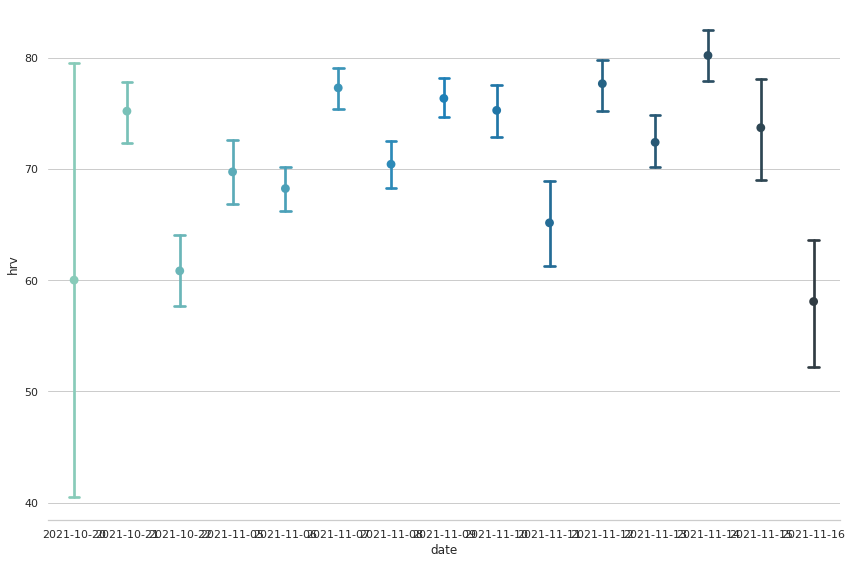

In [70]:
sns.set_theme(style="whitegrid")
g = sns.catplot(x="date", y="hrv", capsize=.2, palette="YlGnBu_d", height=8, aspect=1.5,
                kind="point", data=dfplot)
g.despine(left=True)
# sns.relplot(data=dfplot, x='score', y='normalized', kind='line')
